In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from IPython.display import display as dsp

# United States Drug Prices: Forecasting and Analysis

## Data Collection

In [2]:
#Socrata SQL query
SODA = '$limit=500000'
URL = 'https://data.medicaid.gov/resource/444w-ftrz.csv?{}'.format(SODA)

TRAIN_SPLIT = 0.8

In [28]:
def list_unique_counts(df):
    column_name, unique_values_count, datatype = [], [], []
    results = pd.DataFrame()
    for col in df.columns:
        #print(col, '\t\t\t', len(df[str(col)].unique()))
        column_name.append(col)
        unique_values_count.append(len(df[str(col)].unique()))
        datatype.append(df[str(col)].dtype)
    
    results['Column_Name'] = column_name
    results['Unique_Value_Count'] = unique_values_count
    results['Data_Type'] = datatype
    
    dsp(results)
    print('Total Number of Changes: {}'.format(df.shape[0]))
    
    print('Total Number Observations: ', df.shape[0])

def train_split(df, TRAIN_SPLIT):
    split_point = int(len(df) * (TRAIN_SPLIT))
    train = df[:split_point]
    test = df[split_point:]
    return train, test

def strip_time(date):
    date = date.replace('T00:00:00.000', '')
    return datetime.strptime(date, '%Y-%m-%d')

def return_name(ndc_description):
    if len(ndc_description) == 0:
        return '','','',''
    drug_name, dosage, dosage_unit, drug_form = [], np.nan, np.nan, np.nan
    
    #Check and see if we are dealing with concentration
    concentration = False
    if set('%') <= set(ndc_description):
        concentration = True
        ndc_description.replace('%', '')
    
    #Create our array of words
    words = ndc_description.split()
    
    for i in range(len(words)):
        if not words[i].replace('.','').replace('%', '').isnumeric():
            drug_name.append(words[i])
            
        if words[i].replace('.','').replace('%','').isnumeric():
            dosage = float(words[i].replace('%', ''))
            
            if not concentration:
                try:
                    dosage_unit = words[i + 1]
                    drug_form = ' '.join(words[i + 2:])
                except:
                    drug_form = ' '.join(words[i:])
                    #print(ndc_description, concentration)
                break
            
            if concentration:
                dosage_unit = 'concentration'
                drug_form = ' '.join(words[i + 1:])
                break
            
    drug_name = ' '.join(drug_name)
    return pd.Series([drug_name, dosage, dosage_unit, drug_form])

def drop_na_printout(dataframe):
    i = dataframe.shape[0]
    j = dataframe.dropna().shape[0]
    
    percent_loss = (i - j) / i * 100
    
    print(percent_loss, '% data lost in cleaning.')
    
    return dataframe.dropna()

def one_hot_encoder(series):
    results = pd.DataFrame()
    for entry in series.unique():
        results[str(series.name) + '_' + str(entry)] = series.apply(lambda x: np.where(x == entry, 1, 0))
        
    return results

In [4]:
raw = pd.read_csv(URL, parse_dates = True)

#Convert dates to date format
raw['start_date'] = raw['start_date'].apply(lambda x: strip_time(x))
raw['end_date'] = raw['end_date'].apply(lambda x: strip_time(x))

#Remove Effective Date
raw = raw.drop('effective_date', 1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(raw.columns)

#Create 'days_effective' and 'day_count' columns
raw['days_effective'] = (raw['end_date'] - raw['start_date'])
raw['days_effective'] = raw['days_effective'].apply(lambda x: x.days)

raw['days_count'] = (raw['start_date'] - min(raw['start_date']))
raw['days_count'] = raw['days_count'].apply(lambda x: x.days)

#Create 'month-year' column because most changes happen in the middle of every month
raw['year-month'] = raw['start_date'].apply(lambda x: x.strftime('%Y-%m'))

#Add drug name column, we want to ignore dosage and format
raw[['drug_name', 'dosage','dosage_unit','drug_form']] = \
raw['ndc_description'].apply(lambda x: return_name(x))
    
#Remove all first-date entries
if len(raw['start_date'].unique()) > 1:
    raw.drop(raw[raw['start_date'] == min(raw['start_date'])].index, inplace = True)

#Remove last month of data, this is typically truncated by the limitations of our API call
if len(raw['year-month']) > 3:
    raw.drop(raw[raw['year-month'] == max(raw['year-month'])].index, inplace = True)

dsp(raw.head())

Index(['ndc_description', 'ndc', 'old_nadac_per_unit', 'new_nadac_per_unit',
       'classification_for_rate_setting', 'percent_change', 'primary_reason',
       'start_date', 'end_date'],
      dtype='object')


,ndc_description,ndc,old_nadac_per_unit,new_nadac_per_unit,classification_for_rate_setting,percent_change,primary_reason,start_date,end_date,days_effective,days_count,year-month,drug_name,dosage,dosage_unit,drug_form
24,ALREX 0.2% EYE DROPS,24208035305,27.08802,29.52622,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS
25,ALREX 0.2% EYE DROPS,24208035310,27.39300,29.85892,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS
26,ATIVAN 0.5 MG TABLET,64455006301,4.35697,5.06236,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,0.5,MG,TABLET
27,ATIVAN 1 MG TABLET,64455006401,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET
28,ATIVAN 1 MG TABLET,64455006410,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET


In [6]:
#old_nadac_per_unit, new_nadac_per_unit, classification_for_rate_setting, percent_change, primary_reason, year-month
#drug_name, dosage, dosage_unit, drug_form

In [7]:
raw = drop_na_printout(raw)

13.085503719321077 % data lost in cleaning.


In [30]:
#Scale price to dosage
raw['daily_max_dosage'] = raw.groupby(['drug_name', 'start_date'])['dosage'].transform('max')
raw['scaled_old_per_unit'] = raw['daily_max_dosage'] / raw['dosage'] * raw['old_nadac_per_unit']
raw['scaled_new_per_unit'] = raw['daily_max_dosage'] / raw['dosage'] * raw['new_nadac_per_unit']
raw['scaled_percent_change'] = (raw['scaled_new_per_unit'] - raw['scaled_old_per_unit']) \
/ raw['scaled_old_per_unit'] * 100

In [13]:
raw.head()

,ndc_description,ndc,old_nadac_per_unit,new_nadac_per_unit,classification_for_rate_setting,percent_change,primary_reason,start_date,end_date,days_effective,days_count,year-month,drug_name,dosage,dosage_unit,drug_form,daily_max_dosage,scaled_old_per_unit,scaled_new_per_unit
24,ALREX 0.2% EYE DROPS,24208035305,27.08802,29.52622,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS,0.2,27.08802,29.52622
25,ALREX 0.2% EYE DROPS,24208035310,27.39300,29.85892,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS,0.2,27.39300,29.85892
26,ATIVAN 0.5 MG TABLET,64455006301,4.35697,5.06236,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,0.5,MG,TABLET,2.0,17.42788,20.24944
27,ATIVAN 1 MG TABLET,64455006401,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET,2.0,11.68548,13.57724
28,ATIVAN 1 MG TABLET,64455006410,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET,2.0,11.68548,13.57724


In [ ]:
print('Top value counts for NDC:')
dsp(raw['ndc'].value_counts().sort_values(ascending = False).head())

print('\nTop value counts for NDC description:')
dsp(raw['ndc_description'].value_counts().sort_values(ascending = False).head())

### Normalization

In [ ]:
#Check correlation between dosage and price witin each drug
top_10 = raw['drug_name'].value_counts().sort_values(ascending = False)[:20].index

In [ ]:
#Check correlation between dosage and price within individual drugs
print('Dosage to per-unit price correlation for 10 most changed drugs:\n')
print('(Pearson Correlation Coefficient, P-Value)')
for drug in top_10:
    drug_changelog = raw[raw['drug_name'] == drug]
    print(drug)
    print(stats.pearsonr(drug_changelog['new_nadac_per_unit'].values, drug_changelog['dosage'].values))

In [ ]:
#Create drugs dataframe
drugs = raw[['drug_name','old_nadac_per_unit','new_nadac_per_unit']].groupby(['drug_name']).mean().rename(
    {'old_nadac_per_unit' : 'old_average_per_unit','new_nadac_per_unit': 'new_average_per_unit'}, axis = 1)
drugs['percent_average_change'] = (drugs['new_average_per_unit'] 
                                   - drugs['old_average_per_unit']) / drugs['new_average_per_unit'] * 100

In [ ]:
max_price, min_price, max_dosage = [], [], []
for drug in drugs.index:
    max_price.append(max(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    min_price.append(min(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    max_dosage.append(max(raw[raw['drug_name'] == drug]['dosage']))
drugs['max_per_unit'] = max_price
drugs['min_per_unit'] = min_price
drugs['max_dosage'] = max_dosage
drugs.head()

In [ ]:
plt.title('Max Price per Unit Distribution')
#drugs[(np.abs(stats.zscore(drugs)) < 1).all(axis=1)]
plt.hist(drugs['max_per_unit'])

plt.xlabel('Price per Unit')
plt.show()

## Exploratory Data Analysis

### Metadata

In [31]:
print('\nUnique Values in Raw Data per Column:')
list_unique_counts(raw)


Unique Values in Raw Data per Column:


,Column_Name,Unique_Value_Count,Data_Type
0,ndc_description,4787,object
1,ndc,41876,object
2,old_nadac_per_unit,49345,float64
3,new_nadac_per_unit,49387,float64
4,classification_for_rate_setting,2,object
5,percent_change,6081,float64
6,primary_reason,4,object
7,start_date,107,datetime64[ns]
8,end_date,107,datetime64[ns]
9,days_effective,2,int64


Total Number of Changes: 416775
Total Number Observations:  416775


### Data Distribution

In [68]:
data = raw[['drug_name','start_date', 'year-month', 'old_nadac_per_unit', 'new_nadac_per_unit', 'scaled_old_per_unit',\
          'scaled_new_per_unit', 'percent_change', 'scaled_percent_change']]

#### Percent Change

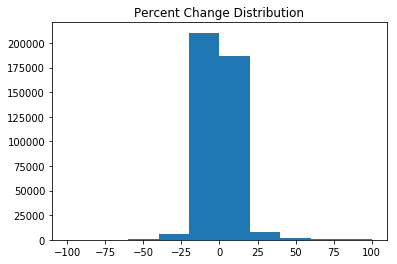

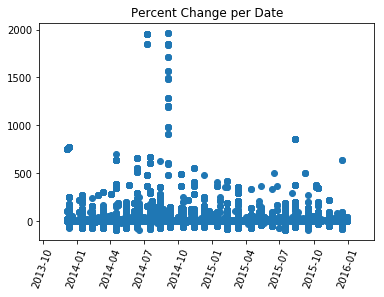

In [64]:
plt.title('Percent Change Distribution')
plt.hist(data['percent_change'], range = (-100, 100))
plt.show()

plt.title('Percent Change per Date')
plt.scatter(data['start_date'], data['percent_change'])
plt.xticks(rotation = 70)
plt.show()

#### Price per Unit: de facto and scaled

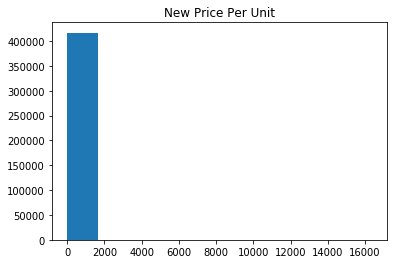

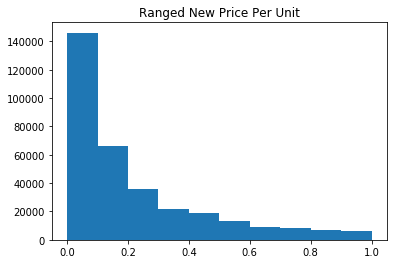

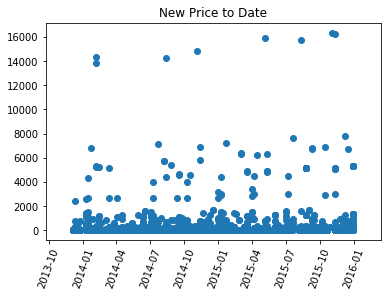

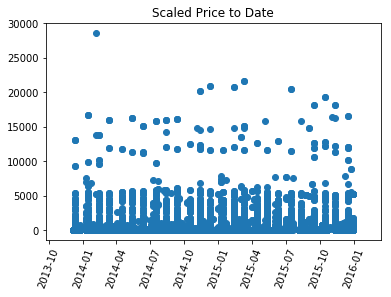

In [76]:
plt.title('New Price Per Unit')
plt.hist(data['new_nadac_per_unit'])
plt.show()

plt.title('Ranged New Price Per Unit')
plt.hist(data['new_nadac_per_unit'], range = (0, 1))
plt.show()

plt.title('New Price to Date')
plt.scatter(data['start_date'], data['new_nadac_per_unit'])
plt.xticks(rotation = 70)
plt.show()

plt.title('Scaled Price to Date')
plt.scatter(data['start_date'], data['scaled_new_per_unit'])
plt.xticks(rotation = 70)
plt.show()

#### Correlation Testing

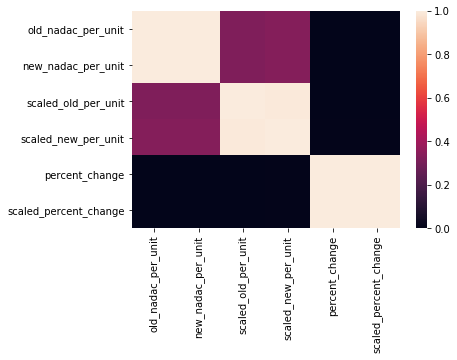

In [75]:
sns.heatmap(data.corr())

### Metrics for General Volatility

#### Changes per Day

In [ ]:
#Changes per day
change_count = raw['start_date'].value_counts().sort_index()
dsp(change_count.head())

print('Our data represents the range of dates between {} and {}'.format(change_count.index.min().strftime('%Y-%m-%d'),
                                                                        change_count.index.max().strftime('%Y-%m-%d')))

In [ ]:
print(change_count.sort_values(ascending = False)[:10])

In [ ]:
plt.title('Changes Implemented Per Day')
plt.plot(change_count.index.strftime('%Y-%m-%d'), change_count.values, '.')
plt.xticks(np.arange(0,len(change_count.index), round((len(change_count.index)) / 8)), rotation = 70)
plt.show()

##### What kind of changes happen at what times.

In [ ]:
#Group dates into high-change days or low change days
CHANGE_LIMIT = 10000

#Group by day
daily = raw.groupby()

#### Changes per Month

In [ ]:
mnth_count = raw['year-month'].value_counts().sort_index()
mnth_count.head()

In [ ]:
plt.title('Changes per Month')
plt.plot(mnth_count)
plt.xticks(np.arange(0,len(mnth_count.index), round((len(mnth_count.index)) / 8)), rotation = 70)
plt.xlabel('date')
plt.ylabel('count')
plt.show()

#### Average Rate Change per Month

In [ ]:
mnth_avgs = raw.groupby(['year-month']).mean()
mnth_avgs.head()

In [ ]:
plt.title('Average Monthly Change')
plt.plot(mnth_avgs['percent_change'])
plt.xticks(np.arange(0,len(mnth_avgs.index), round((len(mnth_avgs.index)) / 8)), rotation = 70)
plt.show()

In [ ]:
plt.title('Average Monthly Percent Change Distribution')
mnth_avgs['percent_change'].hist()
plt.xlabel('Percent Change')
plt.ylabel('Observations')

#### Total Price Gain/Loss per Month

In [ ]:
raw['total_price_change'] = raw['new_nadac_per_unit'] - raw['old_nadac_per_unit']
mnth_sum = raw.groupby(['year-month']).sum()

In [ ]:
plt.title('Total Price Change per Month')
plt.plot(mnth_sum['total_price_change'], '*')
plt.xticks(np.arange(0,len(mnth_sum.index), round((len(mnth_sum.index)) / 8)), rotation = 70)
plt.show()

### Forecasting

#### Generic and Branded

In [ ]:
print('{}% of changes are to generic medicines.'.format(round(len(raw[raw['classification_for_rate_setting'] == 'G'])
                                                              / raw.shape[0], 3) * 100))

raw_generic = raw[raw['classification_for_rate_setting'] == 'G']['percent_change']
raw_branded = raw[raw['classification_for_rate_setting'] == 'B']['percent_change']

#Compare how often and the magnitude of change between generic and branded medicine.
plt.title('Generic and Branded Percent Change Distribution')
plt.hist(raw_generic, normed = True)
plt.hist(raw_branded, normed = True)

plt.xlabel('Percent Change')
plt.show()

#Print Stats
print('Mean Percent Change for Generic Drugs: {}%'.format(round(raw_generic.mean() ,2)))
print('Mean Percent Change for Branded Drugs: {}%'.format(round(raw_branded.mean() ,2)))

print('Standad Deviation for Generic Drugs: {}%'.format(round(raw_generic.std() ,2)))
print('Standad Deviation for Branded Drugs: {}%'.format(round(raw_branded.std() ,2)))

#T-test
t_stat, p_val = stats.ttest_ind(raw_generic, raw_branded)

print('T-Statistic: {}'.format(round(t_stat)))
print('P-Value: {}'.format(round(p_val)))


In [ ]:
print(raw.head())

In [ ]:
#finacl column
#durg_name, start_date, old_nac, new_nadac, classi, percent change(calc again), total_rice_ch (calc again)

#### Individual Drugs

__By NDC Description__

In [ ]:
#Find most frequently changed ndc prices
top_25_desc = raw['drug_name'].value_counts().sort_values(ascending = False)[:25]

#Find Database to group these drugs by their use.
#Create regex to find drug names (ie metformin HCL is all the same) Stop at the number. call it ndc_name of ndc_formula
#These columns can be divided into three: name, dosage, form factor
dsp(top_25_desc)

#Filter raw data for these descriptions
desc_raw_25 = raw[raw['drug_name'].isin(top_25_desc.index)].sort_values('start_date', ascending = True)

dsp(desc_raw_25.head())

#Seperate by the word or words before the number

In [ ]:
#One hot encode important categorical data
#gen_bran = one_hot_encoder(desc_raw_25['classification_for_rate_setting'])
#pri_reas = one_hot_encoder(desc_raw_25['primary_reason'])
#drug_desc = one_hot_encoder(desc_raw_25['ndc_description'])

#CONSOLIDATE THIS
categorical_features = ['classification_for_rate_setting', 'primary_reason', 'drug_name']
cf_dataframe = pd.DataFrame()
for feature in categorical_features:
    cf_dataframe = pd.concat([cf_dataframe, one_hot_encoder(desc_raw_25[feature])], axis = 1, sort = False)

In [ ]:
raw.columns

In [ ]:
#Drop NA
raw.dropna(inplace = True)

#Features and Labels
features = ['days_count', 'old_nadac_per_unit']

labels = ['percent_change']

X_train, X_test = train_split(pd.concat([desc_raw_25[features], cf_dataframe], axis = 1, sort = False), 
                              TRAIN_SPLIT)

#Y_train = desc_raw_25[labels][:]
#Y_test = desc_raw_25[labels][:]
#TO DO: COUNT THE DAYS SINCE EARLIEST IN DATASET
Y_train, Y_test = train_split(desc_raw_25[labels], TRAIN_SPLIT)

print(X_train.shape)
print(X_test.shape)

#dsp(X_train.head())
#dsp(X_train.tail())

#dsp(X_test.head())
#dsp(X_test.tail())

In [ ]:
#Forecasting Modeling Using Neural Nets
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes = (100, 100, 100,))

#Fit and Test
mlp.fit(X_train, Y_train)

In [ ]:
#Model Validation

#Training Set Score
print('Our model has a training set R2 of {}.'.format(round(mlp.score(X_train, Y_train), 4)))
print('Our model has a testing set R2 of {}.'.format(round(mlp.score(X_test, Y_test), 4)))

__BY NDC Number__

In [ ]:
#Find most frequently changed ndc codes
dsp(dsp(raw['ndc'].value_counts().sort_values(ascending = False)[:10]))

#Discus final usage once conclusion is reached.